# Analysis sandbox

for me to try all the things (e.g. behavioural analysis)

In [22]:
import os, numpy as np,pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import math

# MNE functions
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions,plot_highlight_regions
from eegnb.datasets import fetch_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import ttest_ind, ttest_1samp

### code for calculating group averages using Evoked data structure

In [ ]:
subs = [1, 2] # put all the numbers of the subjects you have here
face_TP9 = []
face_TP10 = []
house_TP9 = []
house_TP10 = []

time_windows = [(.16, .24)] 
elecs = ["TP9", "TP10"] # these are the ones of interest for us

for sub in subs:
    
    # load raw file
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
                experiment='visual-N170', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path, verbose=0)
    
    # filter data
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
    
    houses_ev = epochs['House'].average()
    faces_ev = epochs['Face'].average()
    
    for (tmin, tmax) in time_windows:

        houses_ev_roi = houses_ev.copy().pick(elecs).crop(tmin=tmin, tmax=tmax)
        faces_ev_roi = faces_ev.copy().pick(elecs).crop(tmin=tmin, tmax=tmax)
        
        houses_mean_amp = houses_ev_roi.data.mean(axis=1) * 1e6
        faces_mean_amp = faces_ev_roi.data.mean(axis=1) * 1e6
        
        houses_mean_amp_df = pd.DataFrame({
            'ch_name': houses_ev_roi.ch_names,
            'mean_amp': houses_mean_amp
        })
        faces_mean_amp_df = pd.DataFrame({
            'ch_name': faces_ev_roi.ch_names,
            'mean_amp': faces_mean_amp
        })
        
        house_TP9.append(houses_mean_amp_df.iat[0,1])
        house_TP10.append(houses_mean_amp_df.iat[1,1])
        face_TP9.append(faces_mean_amp_df.iat[0,1])
        face_TP10.append(faces_mean_amp_df.iat[1,1])

### code for visualizing data using Evoked data structure

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Trigger channel has a non-zero initial value of -9223372036854775808 (consider using initial_event=True to detect this event)
1346 events found
Event IDs: [ 0  1  2 99]
{'House': <Evoked | 'House' (average, N=640), -0.10156 – 0.80078 sec, baseline off, 4 ch, ~20 kB>, 'Face': <Evoked | 'Face' (average, N=634), -0.10156 – 0.80078 sec, baseline off, 4 ch, ~20 kB>}
['TP9', 'Fp1', 'Fp2', 'TP10'

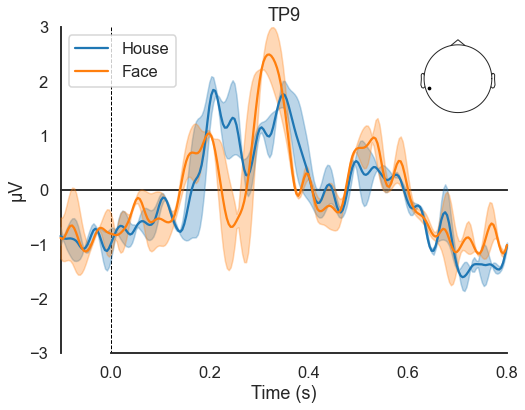

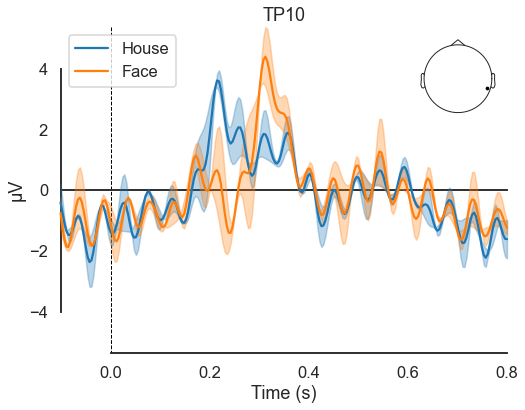

[<Figure size 576x432 with 2 Axes>]

In [19]:
subs = [1, 2] # put all the numbers of the subjects you have here
subcount = 0
conds = ['House','Face']
evokeds = {'House':[],'Face':[]}

eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# filter data
for sub in subs:
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
            experiment='visual-N170', site='local', device_name='muse2_bfn',
            data_dir = eegnb_data_path, verbose=0)
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
            tmin=-0.1, tmax=0.8, baseline=None,
            reject={'eeg': 75e-6}, preload=True, 
            verbose=False, picks=[0,1,2,3])
    
    # make Evoked files
    evoked = {c:epochs[c].average() for c in conds}
    print(evoked)
    
    for cond in conds:
        evokeds[cond].append(evoked[cond])

evokeds

mne.viz.plot_compare_evokeds(evokeds,picks='TP9')
mne.viz.plot_compare_evokeds(evokeds,picks='TP10')

### code for generating difference wave and doing 1-samp t-test

In [23]:
diff_waves = []
for i in range(len(evokeds)):
    diff_waves.append(mne.combine_evoked([evokeds['Face'][i], evokeds['House'][i]],
                                          weights=[1, -1]
                                         )
                     )

diff_waves

evoked_data = np.array([np.mean(e.get_data(picks='TP10', tmin=0.160, tmax=0.240), axis=1) for e in diff_waves])
t, pval = ttest_1samp(evoked_data, 0)
print('Difference t = ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Difference t =  -1.77 p =  0.3274


### annotating behavioural psychopy run for future notice

In [ ]:
def present(duration, subject=0, session=0, **kwargs):
    # create
    info = StreamInfo("Markers", "Markers", 1, 0, "int32", "myuidw43536")

    # next make an outlet
    outlet = StreamOutlet(info)

    # 11-InvalidLeft; 12-InvalidRight; 21-ValidLeft; 22-ValidRight
    markernames = [11, 12, 21, 22]
    # 1 - Cue Left, 2 - Cue Right
    cue_markernames = [1, 2]
    # 31 - incorrect, 32 - Correct
    resp_markernames = [31, 32]

    n_trials = 2010
    instruct = 1
    practicing = 1

    # seconds
    iti = 1
    iti_jitter = 0.2
    cue_target = 1.5
    cue_target_jitter = 0.5
    target_length = 0.05

    cue_validity = 0.80
    record_duration = np.float32(duration)

    target_positions = [-10, 10]
    target_size = [1]

    # Setup log
    tilt = np.random.binomial(1, 0.5, n_trials)
    cues = np.random.binomial(1, 0.5, n_trials)

    trials = DataFrame(dict(tilt=tilt, cues=cues))

    # Instructions function below
    if instruct:
        instructions()
    if practicing:
        practice()

    # graphics
    mywin = visual.Window([1440, 900], monitor="testMonitor", units="deg", fullscr=True)

    mywin.mouseVisible = False

    grating = visual.GratingStim(win=mywin, mask="gauss", size=target_size, sf=5)
    fixation = visual.GratingStim(win=mywin, size=0.2, pos=[0, 0], sf=0)
    cuewin = visual.GratingStim(win=mywin, mask="circle", size=0.5, pos=[0, 1], sf=0)

    # saving trial information for output
    responses = []

    # Get ready screen
    text = visual.TextStim(
        win=mywin,
        text="Find the arrow keys, and begin fixating now. The first trial is about to begin",
        color=[-1, -1, -1],
        pos=[0, 5],
    )
    text.draw()
    fixation.draw()
    mywin.flip()
    core.wait(3)

    # create a clock for rt's
    clock = core.Clock()
    # create a timer for the experiment and EEG markers
    start = time()

    for ii, trial in trials.iterrows():

        til = trials["tilt"].iloc[ii]
        cue = trials["cues"].iloc[ii]
        # cue direction, pick target side
        if cue:
            cuewin.color = [1, 0, 0]
            pos = int(np.random.binomial(1, cue_validity, 1)) # valid cue
        else:
            cuewin.color = [0, 0, 1]
            pos = int(np.random.binomial(1, 1 - cue_validity, 1)) # invalid cue
        # create target
        if pos:
            grating.pos = [10, 0]
        else:
            grating.pos = [-10, 0]

        # 1- Valid cue, 0 - Invalid
        validity = int(not abs(cue - pos))

        # til, 1 - Horizontal, 0 - Vertical
        grating.ori = 90 * til
        grating.phase += np.random.rand()

        ## Trial starts here ##
        # inter trial interval
        core.wait(iti + np.random.rand() * iti_jitter)

        # cueonset
        cuewin.draw()
        fixation.draw()
        t_cueOnset = time()
        # 1 - Cue Left, 2 - Cue Right
        outlet.push_sample([cue_markernames[cue]], t_cueOnset) # sets time for when cue appeared
        mywin.flip()

        # targonset
        core.wait(cue_target + np.random.rand() * cue_target_jitter)
        grating.draw()
        fixation.draw()
        cuewin.draw()
        t_targetOnset = time()

        # 11-InvalidLeft; 12-InvalidRight; 21-ValidLeft; 22-ValidRight
        outlet.push_sample([markernames[pos + (validity * 2)]], t_targetOnset) # sets time for when target appeared
        mywin.flip()

        # response period
        core.wait(target_length)
        fixation.draw()
        t_respOnset = clock.getTime() # sets time for when response period began
        mywin.flip()

        # Wait for response
        keys = event.waitKeys(keyList=["right", "up"], timeStamped=clock) # locked to same clock as response
        # categorize response
        correct = 1
        response = 1
        # if validity:
        # print("Valid Target")
        # else:
        # print("Invalid Target")

        if keys[0][0] == "right":
            # print("pressed horizontal")
            response = 1
            if til:
                # print("Correct")
                correct = 1
            else:
                # print("Incorrect")
                # play sound
                sys.stdout.write("\a")
                correct = 0
        elif keys[0][0] == "up":
            # print("pressed vertical")
            response = 0
            if til:
                # print("Incorrect")
                sys.stdout.write("\a")
                correct = 0
            else:
                # print("Correct")
                correct = 1

        # reset sound
        sys.stdout.flush()

        # meausure RT
        rt = keys[0][1] - t_respOnset # time from when the keys were pressed minus when response onset began
        # print("RT = " + str(np.round(rt*1000)) + " ms")

        # save variables
        tempArray = [ii + 1, cue, pos, validity, til, response, correct, rt * 1000]
        # print(tempArray)
        responses.append(tempArray)
        column_labels = [
            "trial",
            "cue direction",
            "target position",
            "cue validity",
            "target tilt",
            "response",
            "accuracy",
            "rt",
        ]
        # trial number (start at 1)
        # Pos, cue - 1 right
        # validity - 1 valid
        # til = 1 - horizontal; 0 - vertical
        # response - 1 right arrow (horizontal); 0 up arrow (vertical)
        # correct - 1 correct, 0 incorrect
        # rt - ms

        # block end
        if (time() - start) > record_duration:
            break
        event.clearEvents()

    # save the behavioural data into matlab file
    directory = os.path.join(
        os.path.expanduser("~"),
        "eeg-notebooks",
        "data",
        "visual",
        "cueing",
        "subject" + str(subject),
        "session" + str(session),
    )
    if not os.path.exists(directory):
        os.makedirs(directory)
    outname = os.path.join(
        directory,
        "subject"
        + str(subject)
        + "_session"
        + str(session)
        + ("_behOutput_%s.mat" % strftime("%Y-%m-%d-%H.%M.%S", gmtime())),
    )
    output = np.array(responses)
    scipy.io.savemat(outname, {"output": output, "column_labels": column_labels})

    # Overall Accuracy
    print("Overall Mean Accuracy = " + str(round(100 * np.mean(output[:, 6]))))
    # Overall Mean, Median RT
    print("Overall Mean RT = " + str(round(np.mean(output[:, 7]))))
    print("Overall Median RT = " + str(round(np.median(output[:, 7]))))

    ## Mean RT
    print("Valid Mean RT = " + str(round(np.mean(output[output[:, 3] == 1, 7]))))
    print("Invalid Mean RT = " + str(round(np.mean(output[output[:, 3] == 0, 7]))))
    print("Valid Median RT = " + str(round(np.median(output[output[:, 3] == 1, 7]))))
    print("Invalid Median RT = " + str(round(np.median(output[output[:, 3] == 0, 7]))))

    # Goodbye Screen
    text = visual.TextStim(
        win=mywin,
        text="Thank you for participating. Press spacebar to exit the experiment.",
        color=[-1, -1, -1],
        pos=[0, 5],
    )
    text.draw()
    mywin.flip()
    event.waitKeys(keyList="space")

    mywin.mouseVisible = True

    # Cleanup
    mywin.close()


### code for making behavioural data analyses

In [ ]:
# load in subjects
eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')
cueing_data_path = os.path.join(eegnb_data_path, 'visual-cueing', 'local')

# basic numbers
n_subs 
n_sessions
conditions
n_conds

# thresholds for trials that are accepted (not too fast or too slow)
toofast
tooslow

# make arrays to save output
count_rt = np.zeros((n_subs, n_sesh, n_cond))
median_rt = np.zeros((n_subs, n_sesh, n_cond))
prop_accu = np.zeros((n_subs, n_sesh, n_cond))

# load the file
path =  cueing_data_path + '/muse2_bfn/subject' + str('%04.f' %sub) + '/session' + str('%03.f' %(sesh)) + '/'
file =  [x for x in os.listdir(path) if x.endswith('.mat')][0]
output_dict = sio.loadmat(path + file)
print(path + file)

# pull out important info
output = output_dict['output']
accuracy = output[:,6]
rt = output[:,7]
validity = output[:,3]
# print(accuracy,rt,validity)

# median rt on each condition
validRT     =  np.nanmedian(rt[ (validity == 1) &
                              (rt >= rt_toofast) &
                              (rt <= rt_tooslow)])

print('Valid RT = ' + str(validRT) + ' ms')

InvalidRT =  np.nanmedian(rt[ (validity == 0) &
                              (rt >= rt_toofast) &
                              (rt <= rt_tooslow)])

print('Invalid RT = ' + str(InvalidRT) + ' ms')

subs = []

for isub, sub in enumerate(subs):
    print('Subject - ' + str(sub))
    for sesh in range(n_sesh):
        # get the path and file name and load data
        #path =  './subject' + str(sub) + '/session' + str(sesh+1) + '/'
        path =  cueing_data_path + '/muse2016/subject' + str('%04.f' %sub) + '/session' + str('%03.f' %(sesh+1)) + '/'
            # sesh has +1 because range() starts from 0
            
        file =  [x for x in os.listdir(path) if x.endswith('.mat')][0]
        output_dict = sio.loadmat(path + file)

        # pull out important stuff
        output = output_dict['output']
        accuracy = output[:,6]
        rt = output[:,7]
        validity = output[:,3]

        # median rt on each condition
        median_rt[isub,sesh,:] = [np.nanmedian(rt[ (validity == 1) & (rt >= rt_toofast) & (rt <= rt_tooslow)]),
                                 np.nanmedian(rt[ (validity == 0) & (rt >= rt_toofast) & (rt <= rt_tooslow)]) ]

        # proportion accurate (number accurate / count), for valid then invalid
        prop_accu[isub,sesh,:] = [ np.sum(accuracy[(validity == 1) & (rt >= rt_toofast) & (rt <= rt_tooslow)]) /
                                   np.sum((validity == 1) & (rt >= rt_toofast) & (rt <= rt_tooslow)),
                                   np.sum(accuracy[(validity == 0) & (rt >= rt_toofast) & (rt <= rt_tooslow)]) /
                                   np.sum((validity == 0) & (rt >= rt_toofast) & (rt <= rt_tooslow)) ]
        
# Summary stats and collapse sessions
Out_median_RT = np.squeeze(np.nanmean(median_rt,axis=1))
Out_prop_accu = np.squeeze(np.nanmean(prop_accu,axis=1))

print('Median RT')
print(Out_median_RT)
print('Proportion Accurate')
print(Out_prop_accu)

# bar plot results
plt.figure()

# Accuracy
ax = plt.subplot(211)
plt.bar([0,1], np.nanmean(Out_prop_accu,axis=0), 0.6, yerr = np.nanstd(Out_prop_accu,axis=0)/np.sqrt(n_subs))
plt.ylim(.9,.96)
plt.title('Accuracy')
plt.ylabel('Proportion Correct')
ax.set_xticks([0,1])
ax.set_xticklabels(conditions)

# RT
ax = plt.subplot(212)
plt.bar([0,1], np.nanmean(Out_median_RT,axis=0), 0.6, yerr = np.nanstd(Out_median_RT,axis=0)/np.sqrt(n_subs))
plt.ylim(450,600)
plt.title('Reaction Time')
plt.ylabel('RT (ms)')
plt.xlabel('Condition')
ax.set_xticks([0,1])
ax.set_xticklabels(conditions)
plt.show()